In [1]:
# Importing libraries and preprocessing scripts
import os
import numpy as np
import pandas as pd
import rioxarray as rxr
import xarray as xr
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler
from pickle import dump , load

import importlib
import sys
sys.path.append('../src/')
import data_processing as ppf
importlib.reload(ppf)

this_path = os.getcwd()
print(this_path)

/home/jemima/Data/NigerDelta_MangroveClassification/scripts


# Processing Exported Geotiffs - Production Data

In [2]:
outpath = "../production_data/riverstate/"
dirpath = "../raw_data/riverstate/"

In [3]:
ppf.stackbytime(dirpath,outpath,2016,2023,save_file=True)

Stacking -  2016
Stacking -  2017
Stacking -  2018
Stacking -  2019
Stacking -  2020
Stacking -  2021
Stacking -  2022
Stacking -  2023


In [5]:
da_2016 = xr.open_dataset(outpath+'2016.nc')['__xarray_dataarray_variable__'] # read back in as follows
da_2016

<xarray.DataArray '__xarray_dataarray_variable__' (time: 1, y: 7756, x: 5569,
                                                   band: 57)> Size: 10GB
[2462010348 values with dtype=float32]
Coordinates:
  * time     (time) <U4 16B '2016'
  * x        (x) float64 45kB 2.78e+05 2.78e+05 2.78e+05 ... 3.337e+05 3.337e+05
  * y        (y) float64 62kB 5.419e+05 5.419e+05 ... 4.644e+05 4.644e+05
  * band     (band) <U18 4kB 'VV_median' 'VH_median' ... 'VH_asm_max'
Attributes:
    AREA_OR_POINT:  Area
    long_name:      ['VV_median', 'VH_median', 'angle_median', 'VV_contrast_m...
    grid_mapping:   spatial_ref

# Open and Examine Training Data

In [9]:
training_df = pd.read_csv("./NigerDelta_MangroveClassification_Clean/training_data/training_cleaned_scaled.csv").drop('Unnamed: 0',axis=1)
display(training_df.head(5))

stats_df = training_df.groupby('class').agg(['mean'])
stats_df.index = ['Degraded','Standard mangroves','Tall mangroves']
stats_df

,VH_asm_max,VH_asm_median,VH_asm_min,VH_contrast_max,VH_contrast_median,VH_contrast_min,VH_corr_max,VH_corr_median,VH_corr_min,VH_diss_max,...,VV_max,VV_median,VV_min,VV_savg_max,VV_savg_median,VV_savg_min,VV_var_max,VV_var_median,VV_var_min,class
0,-1.236907,-1.400623,-1.384210,1.813992,1.951980,0.886042,-1.075731,-0.285334,-0.592923,2.062100,...,-1.163166,-1.222510,-1.351630,-1.531842,-1.370806,-1.653016,0.004966,0.100540,0.865888,0
1,-0.973142,-1.460545,-1.384210,-0.032337,1.527404,0.761886,-0.676473,0.695505,-0.338982,0.403395,...,2.295820,0.486456,-0.540576,1.055520,0.440699,-0.654935,0.676143,1.293084,0.193894,0
2,-1.036130,-1.235839,-0.845134,0.395409,0.792562,1.382665,-0.636870,1.119029,0.595341,0.646132,...,-1.854963,-0.795269,-0.540576,-1.580507,-0.778840,-0.572335,0.699921,0.585625,0.193894,0
3,-1.658144,-1.325722,-1.144620,1.933378,0.384315,1.879288,-0.799962,1.278725,-0.347519,1.728336,...,-1.163166,-1.222510,-2.365447,-1.110078,-1.201672,-2.692396,3.991149,0.079854,1.605760,0
4,-2.083318,-1.415604,-1.144620,4.488361,2.262247,3.989937,-0.589947,0.030563,-1.068857,4.297306,...,-0.471369,-3.785959,-2.770974,-1.361514,-3.800982,-2.724519,3.138894,2.915897,-0.831066,0


,VH_asm_max,VH_asm_median,VH_asm_min,VH_contrast_max,VH_contrast_median,VH_contrast_min,VH_corr_max,VH_corr_median,VH_corr_min,VH_diss_max,...,VV_idm_min,VV_max,VV_median,VV_min,VV_savg_max,VV_savg_median,VV_savg_min,VV_var_max,VV_var_median,VV_var_min
,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,...,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean
Degraded,-0.820983,-1.158302,-1.088410,1.151951,1.241529,0.874221,-0.525895,0.388341,-0.078995,1.298834,...,-1.164409,-0.707726,-1.219702,-1.352022,-0.876202,-1.238015,-1.381134,1.146237,1.095011,0.570279
Standard mangroves,0.573132,0.838079,0.672520,-0.433114,-0.562138,-0.553209,0.496173,-0.190369,0.035589,-0.535584,...,0.664148,0.482257,0.642165,0.587607,0.617209,0.652546,0.594189,-0.498428,-0.545323,-0.445220
Tall mangroves,0.004375,-0.022809,0.091678,-0.371147,-0.306222,-0.060816,-0.124134,-0.081484,0.019659,-0.371999,...,0.152508,0.015388,0.212396,0.357634,-0.000769,0.214858,0.371306,-0.302947,-0.221367,0.043297


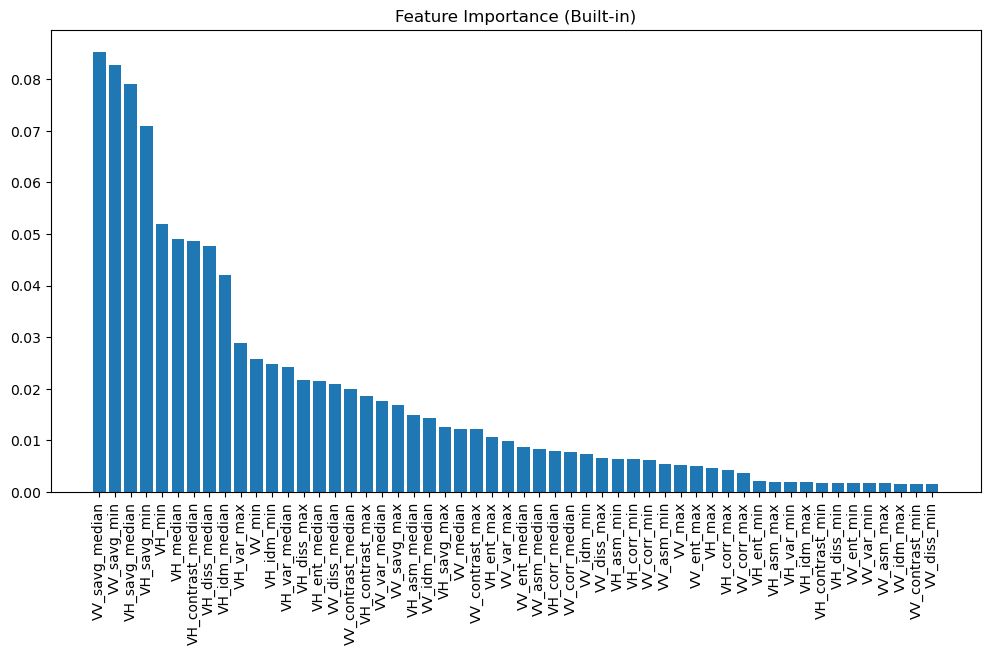

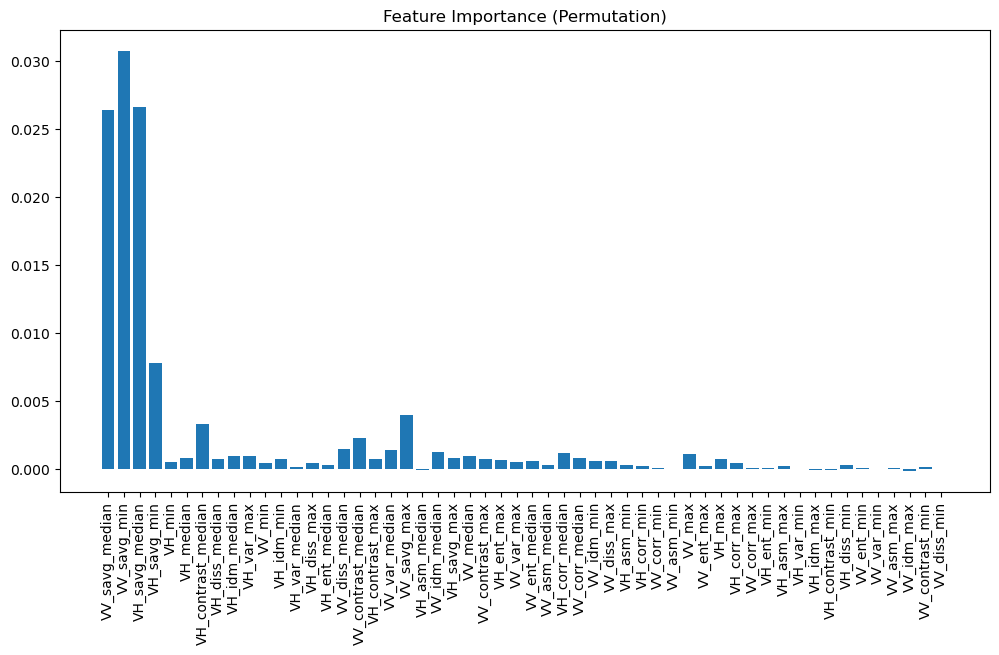

In [10]:
var_colums = [c for c in training_df.columns if c not in  ['class']]
X = training_df.loc[:,var_colums]
y = training_df.loc[:,'class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

importances = clf.feature_importances_
sorted_indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 6))
plt.bar(range(X.shape[1]), importances[sorted_indices], align="center")
plt.xticks(range(X.shape[1]), [var_colums[i] for i in sorted_indices], rotation=90)
plt.title("Feature Importance (Built-in)")
plt.show()

perm_importance = permutation_importance(clf, X_test, y_test, random_state=42)

plt.figure(figsize=(12, 6))
plt.bar(range(X.shape[1]), perm_importance.importances_mean[sorted_indices], align="center")
plt.xticks(range(X.shape[1]), [var_colums[i] for i in sorted_indices], rotation=90)
plt.title("Feature Importance (Permutation)")
plt.show()

In [11]:
feature_importance_df = pd.DataFrame({
    'feature': var_colums,
    'importance': importances
}).sort_values(by='importance', ascending=False)


feature_importance_df['Cumulative Importance'] = feature_importance_df['importance'].cumsum()

# Set a cutoff threshold (e.g., 95% cumulative importance)
cutoff = 0.95

# Select features where cumulative importance is below the cutoff
selected_features = feature_importance_df[feature_importance_df['Cumulative Importance'] <= cutoff]['feature'].values

print("Selected features based on cumulative importance cutoff:")
print((selected_features))

Selected features based on cumulative importance cutoff:
['VV_savg_median' 'VV_savg_min' 'VH_savg_median' 'VH_savg_min' 'VH_min'
 'VH_median' 'VH_contrast_median' 'VH_diss_median' 'VH_idm_median'
 'VH_var_max' 'VV_min' 'VH_idm_min' 'VH_var_median' 'VH_diss_max'
 'VH_ent_median' 'VV_diss_median' 'VV_contrast_median' 'VH_contrast_max'
 'VV_var_median' 'VV_savg_max' 'VH_asm_median' 'VV_idm_median'
 'VH_savg_max' 'VV_median' 'VV_contrast_max' 'VH_ent_max' 'VV_var_max'
 'VV_ent_median' 'VV_asm_median' 'VH_corr_median' 'VV_corr_median'
 'VV_idm_min' 'VV_diss_max' 'VH_asm_min' 'VH_corr_min']


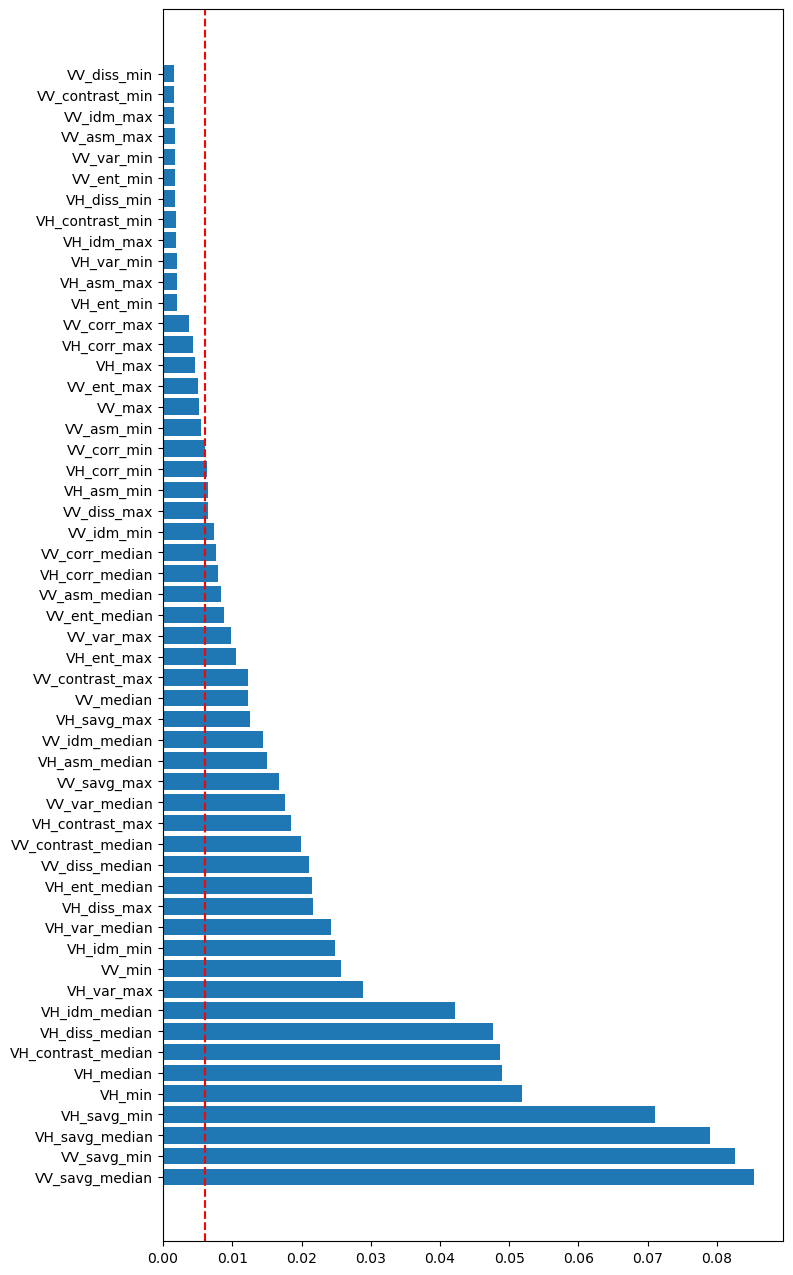

In [12]:
plt.figure(figsize=(8,16))
plt.barh(feature_importance_df['feature'], feature_importance_df['importance'])
plt.axvline(x=0.006103,color='r', linestyle='--')
plt.show()

In [38]:
training_df_filt = training_df.set_index('class')[selected_features]
training_df_filt.to_csv("./NigerDelta_MangroveClassification_Clean/training_data/training_cleaned_scaled_fsel.csv")

In [17]:
df_training = pd.read_csv("./NigerDelta_MangroveClassification/training_data/training_cleaned.csv").drop('Unnamed: 0',axis=1)
training_data = df_training.set_index('class')[selected_features]
display(training_data.head(5))

scaler = StandardScaler()
scaled_training_data = scaler.fit_transform(training_data.values)
outpath = "./NigerDelta_MangroveClassification_Clean/training_data/training_cleaned_scaled_fsel.csv"
scaled_training_data = pd.DataFrame(scaled_training_data, index=training_data.index, columns=training_data.columns)
scaled_training_data.to_csv(outpath)
scaled_training_data.head(5)

,VV_savg_median,VV_savg_min,VH_savg_median,VH_savg_min,VH_min,VH_median,VH_contrast_median,VH_diss_median,VH_idm_median,VH_var_max,...,VH_ent_max,VV_var_max,VV_ent_median,VV_asm_median,VH_corr_median,VV_corr_median,VV_idm_min,VV_diss_max,VH_asm_min,VH_corr_min
class,,,,,,,,,,,,,,,,,,,,,
2,-18.791667,-34.229167,-38.000000,-60.770833,-28,-19.0,3.979167,1.520833,0.441667,49.049913,...,2.282174,4.437066,1.567225,0.223958,-0.012016,-7.077672e-15,0.327304,2.520833,0.104167,-0.433807
2,-10.312500,-25.166667,-28.895833,-39.604167,-20,-14.0,3.437500,1.520833,0.442770,12.060330,...,2.282174,7.622396,1.848957,0.177083,0.039364,-1.621608e-02,0.297087,2.750000,0.104167,-0.419432
2,-16.020833,-24.416667,-31.604167,-37.875000,-20,-16.0,2.500000,1.187500,0.525000,19.325955,...,2.238852,7.735243,1.762314,0.190972,0.061550,6.154979e-02,0.228337,2.875000,0.111979,-0.366540
2,-18.000000,-43.666667,-36.645833,-60.375000,-35,-18.0,1.979167,1.125000,0.528676,41.454861,...,2.253293,23.355035,1.704551,0.200521,0.069915,7.328895e-02,0.123342,5.125000,0.107639,-0.419915
2,-30.166667,-43.958333,-43.062500,-76.083333,-45,-20.0,4.375000,1.562500,0.426593,55.394097,...,2.253293,19.310330,1.928239,0.157986,0.004532,-1.504014e-02,0.180638,4.812500,0.107639,-0.460750


,VV_savg_median,VV_savg_min,VH_savg_median,VH_savg_min,VH_min,VH_median,VH_contrast_median,VH_diss_median,VH_idm_median,VH_var_max,...,VH_ent_max,VV_var_max,VV_ent_median,VV_asm_median,VH_corr_median,VV_corr_median,VV_idm_min,VV_diss_max,VH_asm_min,VH_corr_min
class,,,,,,,,,,,,,,,,,,,,,
2,-1.370806,-1.653016,-2.020147,-2.245461,-1.379450,-2.058817,1.951980,1.786164,-1.793706,2.322040,...,1.442303,0.004966,0.330899,-0.607232,-0.285334,-0.242872,-0.338927,0.462849,-1.384210,-0.592923
2,0.440699,-0.654935,-0.314287,-0.405719,-0.203778,-0.175932,1.527404,1.786164,-1.782756,0.114066,...,1.442303,0.676143,1.505748,-1.349637,0.695505,-0.533937,-0.615323,0.700140,-1.384210,-0.338982
2,-0.778840,-0.572335,-0.821751,-0.255425,-0.203778,-0.929086,0.792562,0.861769,-0.966430,0.547764,...,0.996324,0.699921,1.144437,-1.129665,1.119029,0.861897,-1.244171,0.829572,-0.845134,0.595341
2,-1.201672,-2.692396,-1.766415,-2.211056,-2.408163,-1.682240,0.384315,0.688445,-0.929932,1.868678,...,1.144984,3.991149,0.903563,-0.978435,1.278725,1.072606,-2.204548,3.159340,-1.144620,-0.347519
2,-3.800982,-2.724519,-2.968714,-3.576377,-3.877754,-2.435394,2.262247,1.901713,-1.943345,2.700736,...,1.144984,3.138894,1.836361,-1.652099,0.030563,-0.512830,-1.680473,2.835761,-1.144620,-1.068857


In [20]:
scaler = StandardScaler()
scaled_training_data = scaler.fit_transform(training_data.values)
dump(scaler, open('./NigerDelta_MangroveClassification_Clean/model_versions/std_scaler.pkl', 'wb'))